In [1]:
%env CUDA_LAUNCH_BLOCKING=1
%load_ext autoreload
%autoreload complete
# %aimport ...

import sys
import importlib
import warnings

importlib.invalidate_caches()

for mod_name in list(sys.modules):
    if not (str.startswith(mod_name, "robotodo") or str.startswith(mod_name, "tensorspecs")):
        continue
    try:
        importlib.reload(sys.modules[mod_name])
    except Exception as error:
        warnings.warn(f"{error}")

from robotodo.engines.isaac._kernel import Kernel

kernel = Kernel([
    "--/log/file=/tmp/todo-isaacsim.log",
    # "--/log/enableStandardStreamOutput=true",
    "--/app/enableStdoutOutput=true",
    # "--no-window",
    # TODO
    # "--/app/content/emptyStageOnStart=false",
    # "--/app/asyncRendering=true",
    # "--enable", "isaacsim.exp.full",
    "--/app/vulkan=",
    # TODO
    "--/app/useFabricSceneDelegate=false",
], kit_path="isaacsim.exp.full.kit")
kernel.start_app_loop_soon()

env: CUDA_LAUNCH_BLOCKING=1
[Warning] [simulation_app] Interactive python shell detected but ISAAC_JUPYTER_KERNEL was not set. Problems with asyncio may occur
[Warning] [simulation_app] Please use Isaac Sim Python 3 kernel instead of the default Python 3 Kernel
Loading user config located at: '/home/sysadmin/lab/robotodo/.conda/lib/python3.11/site-packages/omni/data/Kit/Isaac-Sim Full/5.0/user.config.json'
[0.106s] [ext: omni.kit.async_engine-0.0.3] startup
[0.397s] [ext: omni.metrics.core-0.0.3] startup
[0.398s] [ext: omni.client.lib-1.1.0] startup
[0.412s] [ext: omni.blobkey-1.1.2] startup
[0.413s] [ext: omni.stats-1.0.1] startup
[0.414s] [ext: omni.datastore-0.0.0] startup
[0.420s] [ext: omni.client-1.3.0] startup
[0.476s] [ext: omni.ujitso.default-1.0.0] startup
[0.478s] [ext: omni.hsscclient-1.1.2] startup
[0.484s] [ext: omni.gpu_foundation.shadercache.vulkan-1.0.0] startup
[0.486s] [ext: omni.assets.plugins-0.0.0] startup
[0.488s] [ext: omni.gpu_foundation-0.0.0] startup
[0.498s]

2025-10-31T02:38:50Z s] [Error] [omni.gpu_foundation_factory.plugin] Start up failed. The default graphics plugin cannot be set!



|---------------------------------------------------------------------------------------------|
| Driver Version: 535.247.01    | Graphics API: Vulkan
|=============================================================================================|
| GPU | Name                             | Active | LDA | GPU Memory | Vendor-ID | LUID       |
|     |                                  |        |     |            | Device-ID | UUID       |
|     |                                  |        |     |            | Bus-ID    |            |
|---------------------------------------------------------------------------------------------|
| 0   | NVIDIA GeForce RTX 3060          | Yes: 0 |     | 12288   MB | 10de      | 0          |
|     |                                  |        |     |            | 2504      | 3157457f.. |
|     |                                  |        |     |            | 1         |            |
|===============================================================================

2025-10-31T02:39:03Z [14,012ms] [Error] [isaacsim.ros2.bridge.impl.extension] ROS2 Bridge startup failed


[14.882s] [ext: omni.kit.registry.nucleus-0.0.0] startup
[15.183s] app ready


2025-10-31T02:39:04Z [15,195ms] [Error] [carb.graphics-vulkan.plugin] Could not get NGX parameters block because NGX isn't enabled.
2025-10-31T02:39:04Z [15,195ms] [Error] [carb.graphics-vulkan.plugin] Failed to create NGX context.
2025-10-31T02:39:05Z [15,312ms] [Error] [rtx.optixdenoising73.plugin] Failed to create an Optix adaptor for device 0


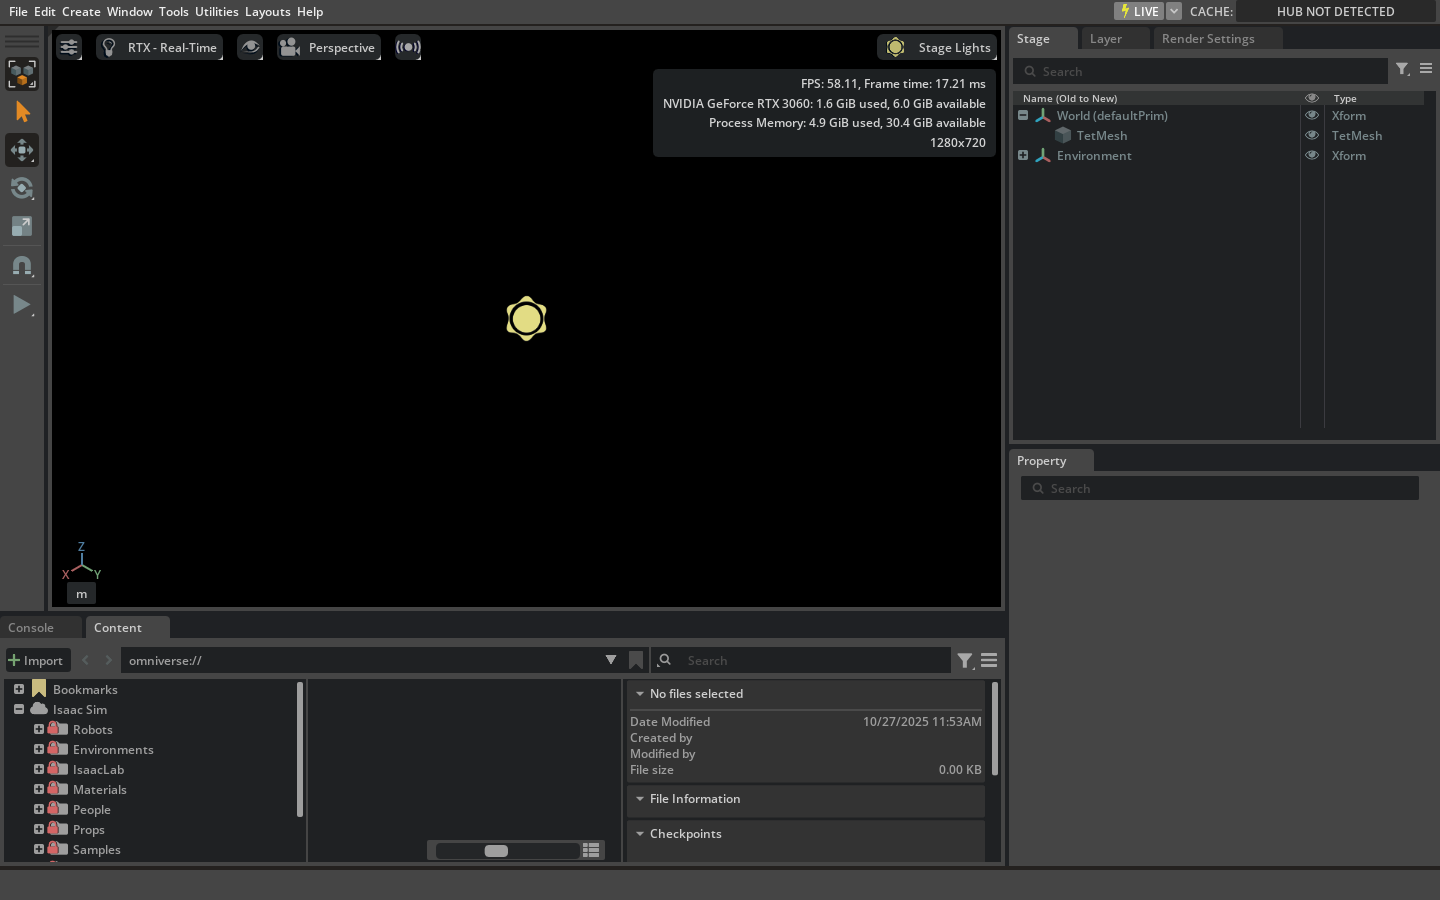

In [10]:
import ctypes

import omni
import numpy


def _todo_read_framebuffer(callback: ...):
    def _next_frame_swapchain_callback(buffer, buffer_size, width, height, buffer_format):
        ctypes.pythonapi.PyCapsule_GetPointer.restype = ctypes.POINTER(ctypes.c_byte * buffer_size)
        ctypes.pythonapi.PyCapsule_GetPointer.argtypes = [ctypes.py_object, ctypes.c_char_p]
        pointer = ctypes.pythonapi.PyCapsule_GetPointer(buffer, None)

        match buffer_format:
            case buffer_format.BGRA8_UNORM:
                arr = (
                    numpy.frombuffer(pointer.contents, dtype=numpy.uint8)
                    .reshape((height, width, 4), order="C")
                )
            case _:
                # TODO 
                raise NotImplementedError("TODO")

        callback(arr)

    window_factory = omni.appwindow.acquire_app_window_factory_interface()
    app_window = window_factory.get_default_window()

    renderer_capture = omni.kit.renderer_capture.acquire_renderer_capture_interface()
    # TODO
    return renderer_capture.capture_next_frame_swapchain_callback(
        _next_frame_swapchain_callback, 
        # TODO
        app_window=app_window,
    )

@_todo_read_framebuffer
def _(arr):
    from PIL import Image
    display(Image.fromarray(arr, 'RGBA'))

In [3]:
from robotodo.engines.isaac.scene import Scene

scene = Scene(_kernel=kernel)
stage = scene._usd_stage

In [4]:
from pxr import Usd, UsdGeom, Vt, Gf

def create_trimesh(stage, path, res):
    triMesh = UsdGeom.Mesh.Define(stage, path)
    step = 1.0 / res
    verts = [(i * step, j * step, 0.0) for j in range(res + 1) for i in range(res + 1)]
    idx = lambda i, j: j * (res + 1) + i
    tris = [(idx(i,j), idx(i+1,j), idx(i+1,j+1)) + (idx(i,j), idx(i+1,j+1), idx(i,j+1))
            for j in range(res) for i in range(res)]
    triMesh.GetPointsAttr().Set(Vt.Vec3fArray(verts))
    triMesh.GetFaceVertexCountsAttr().Set([3] * (2 * res**2))
    triMesh.GetFaceVertexIndicesAttr().Set([i for t in tris for i in t])
    return triMesh

In [5]:
triMesh = create_trimesh(stage, "/World/TriMesh", 6)


In [5]:
UsdGeom.Plane.Define(stage, "/todo/a")

UsdGeom.Plane(Usd.Prim(</todo/a>))

In [4]:
from pxr import Usd, UsdGeom, Vt, Gf

def create_simulation_tetmesh(stage, path, add_surface=False):

    # Create a tet mesh prim
    tetMesh = UsdGeom.TetMesh.Define(stage, path)

    # Set the points
    points = Vt.Vec3fArray([
        (0, 0, 0), (1, 0, 0), (1, 1, 0), (0, 1, 0),
        (0, 0, 1), (1, 0, 1), (1, 1, 1), (0, 1, 1),
    ])

    # Define three tetrahedra
    tetVtxIndices = Vt.Vec4iArray([
        (0, 1, 3, 4), (1, 2, 3, 6), (1, 4, 5, 6), (3, 4, 6, 7), (1, 3, 4, 6),
    ])

    tetMesh.GetPointsAttr().Set(points)
    tetMesh.GetTetVertexIndicesAttr().Set(tetVtxIndices)

    # Adding surface information for collision detection
    if add_surface:
        surfaceFaceVertexIndices = UsdGeom.TetMesh.ComputeSurfaceFaces(tetMesh)
        tetMesh.GetSurfaceFaceVertexIndicesAttr().Set(surfaceFaceVertexIndices)

    return tetMesh


tetMesh = create_simulation_tetmesh(stage, "/World/TetMesh", add_surface=True)


In [6]:
tetMesh.ComputeEffectiveVisibility()

'visible'

In [12]:
import pxr

pxr.UsdGeom.TetMesh.ComputeSurfaceFaces(tetMesh)

Vt.Vec3iArray(12, (Gf.Vec3i(0, 1, 4), Gf.Vec3i(0, 3, 1), Gf.Vec3i(0, 4, 3), Gf.Vec3i(1, 2, 6), Gf.Vec3i(1, 3, 2), Gf.Vec3i(1, 5, 4), Gf.Vec3i(1, 6, 5), Gf.Vec3i(2, 3, 6), Gf.Vec3i(3, 4, 7), Gf.Vec3i(3, 7, 6), Gf.Vec3i(4, 5, 6), Gf.Vec3i(4, 6, 7)))